In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression


In [6]:
cols = ['bike_count','hour','temp','humidity','wind','visibility','Dew_pt_temp','radiation','rain','snow','functional']
df = pd.read_csv('SeoulBikeData.csv',encoding ='latin-1').drop(['Date','Holiday','Seasons'],axis=1)

In [7]:
df.columns = cols
df['functional'] =(df['functional']=='Yes').astype(int)
df =df[df['hour']==12]
df =df.drop(['hour'],axis=1)

In [8]:
df.head()

,bike_count,temp,humidity,wind,visibility,Dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


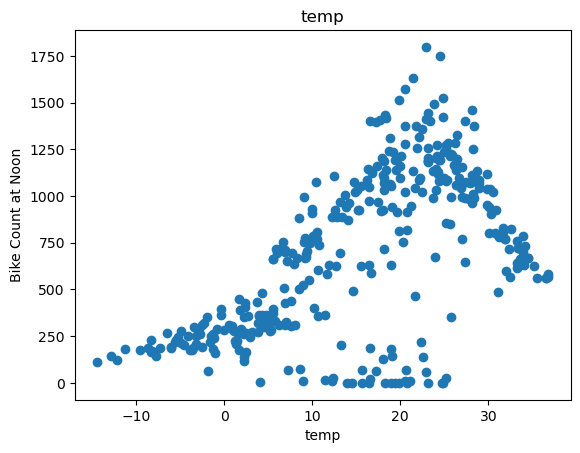

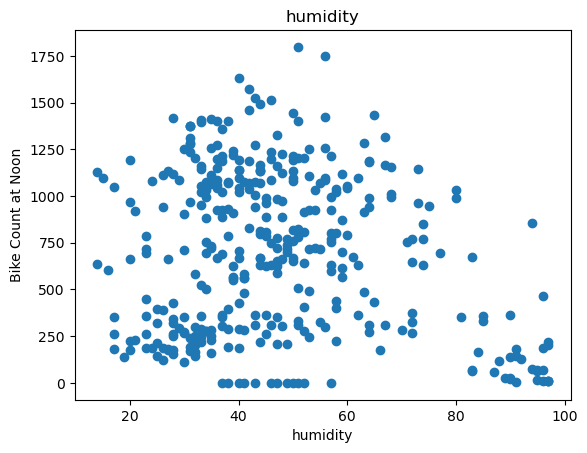

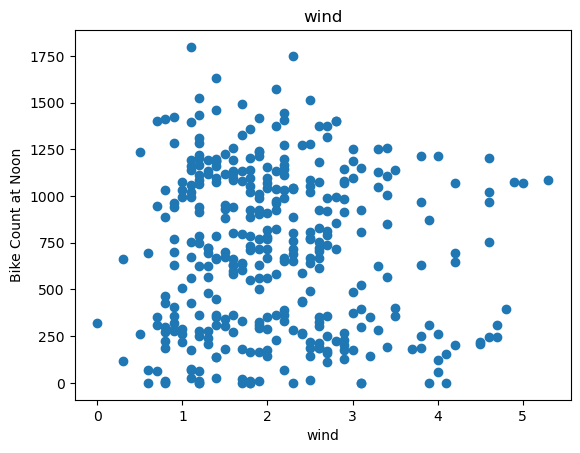

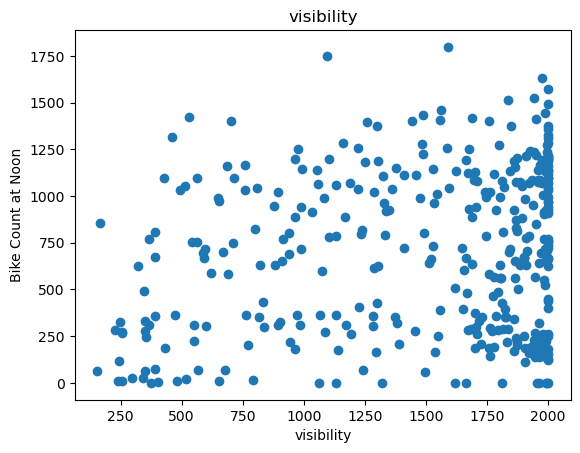

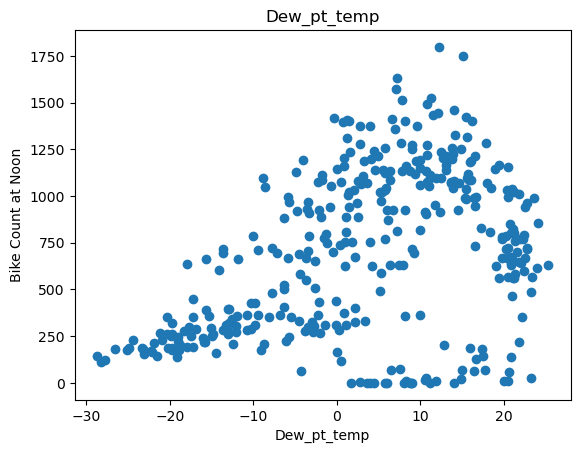

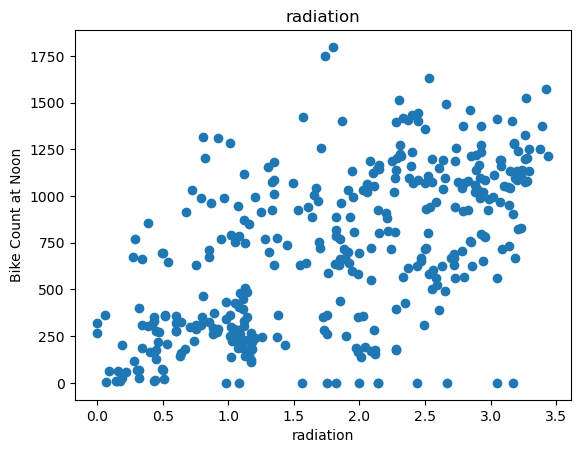

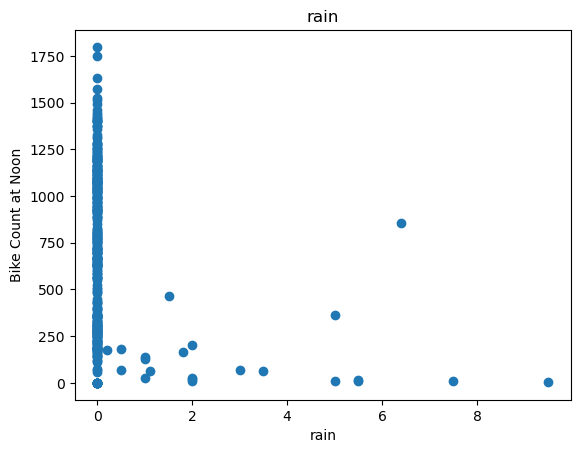

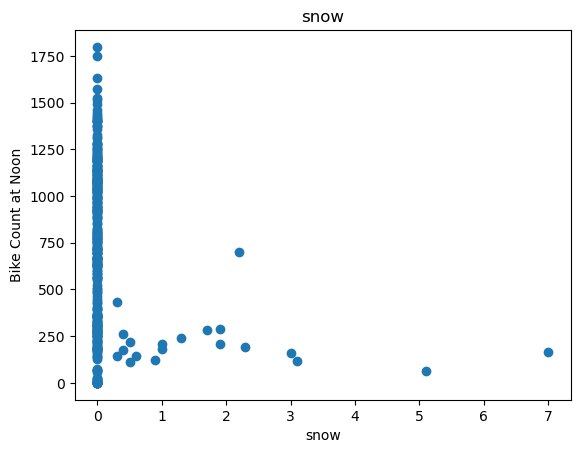

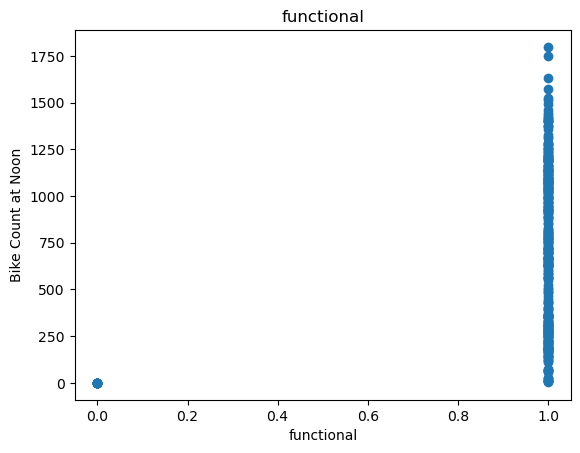

In [9]:
for label in df.columns[1:]:
    plt.scatter(df[label],df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()
    # wind , visibility, functional

In [10]:
df = df.drop(['wind','visibility','functional'],axis=1)
df.head()

,bike_count,temp,humidity,Dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train , Valid and Test DataSet

In [12]:
train,val,test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

C:\Users\negip\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Code Explaination
 1. df.sample(frac=1)  : This randomly shuffles all rows of your DataFrame.

        frac=1 means “take 100% of the data (i.e., all rows), but in random order.”
        👉 So this ensures your train/val/test sets are randomly distributed — not in time   order or grouped.
 2. len(df) : the total number of rows in your dataset.
 3. [int( 0.6*len(df) ) , int( 0.8*len(df) )] : These are the split indices:

    int(0.6*len(df)) → 60% of the data (end of training set)
    int(0.8*len(df)) → 80% of the data (end of validation set)

    So:
        First 60% → training
        Next 20% → validation
        Last 20% → test

In [14]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe([c for c in dataframe.columns if c!= y_label]).values
    else:
        X =dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))

    return data, X, y

# Step-by-step explanation
1. Function definition:

           def get_xy(dataframe, y_label, x_labels=None):

                   y_label: the column name you want as your target (Y).

                   x_labels: optional — the specific columns you want as features (X).

                   If not given, it will use all columns except the target.

3. Deep copy


        dataframe = copy.deepcopy(dataframe)

Makes a completely independent copy of the DataFrame, so any changes here won’t affect the original.

3. Select X features

       if not x_labels:
            x = dataframe[[c for c in dataframe.columns if c != y_label]].values
        else:
            x = dataframe[x_labels].values

If you didn’t specify x_labels, it automatically picks all columns except the target column (y_label).
.values converts the selected columns to a NumPy array.

✅ Example:
If your DataFrame has columns:

    X_labels = ['Temperature', 'Humidity', 'Windspeed', 'BikeCount']

you call:
        get_xy(df, y_label='BikeCount')

            Then x =  ['Temperature', 'Humidity', 'Windspeed']

4. Select Y target
            y = dataframe[y_label].values.reshape(-1, 1)


        Takes the target column as a NumPy array.

        .reshape(-1, 1) turns it into a column vector shape (n rows × 1 column).

    Example:   [254, 204, 173]  →  [[254],
                                    [204],
                                    [173]]

6. Combine X and Y horizontally
data = np.hstack((x, y))

7. return data, x, y

    Returns:

    data: combined [X | Y]

    x: features only

    y: target only

In [16]:
_, X_train_temp,y_train_temp = get_xy(train,'bike_count',x_labels =['temp'])
_, X_val_temp,y_val_temp = get_xy(val,'bike_count',x_labels =['temp'])
_, X_test_temp,y_test_temp =get_xy(test,'bike_count',x_labels =['temp'])

# Code Explaination
1. X_train_temp,y_train_temp = get_xy(train,'bike_count',x_labels =['temp'])

   it call the function def get_xy()
       where :
               dataframe =train , y_label = bike_count , x_labels = ['temp']
               X contains x_labels.values , y contains y_labels
   return :data =[X|y], X,y

Similarly, for Validation Dataset , Test Dataset

In [18]:
temp_reg =LinearRegression()
temp_reg.fit(X_train_temp,y_train_temp)

LinearRegression()

In [19]:
#print(temp_reg.coef_,temp_reg.intercept_)

temp_reg.score(X_test_temp,y_test_temp)

0.2798466550890357

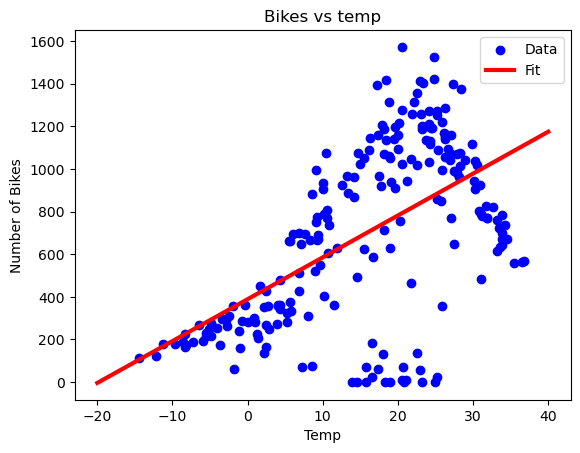

In [20]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color ='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)),label='Fit',color = 'red',linewidth=3)
plt.legend()
plt.title('Bikes vs temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Regression

In [22]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'Dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [55]:
train,val,test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])
_, X_train_all,y_train_all = get_xy(train,'bike_count',x_labels =df.columns[1:])
_, X_val_all,y_val_all = get_xy(val,'bike_count',x_labels =df.columns[1:])
_, X_test_all,y_test_all =get_xy(test,'bike_count',x_labels =df.columns[1:])

C:\Users\negip\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(219, 6)

In [24]:
all_reg =LinearRegression()
all_reg.fit(X_train_all,y_train_all)

LinearRegression()

In [25]:
all_reg.score(X_test_all, y_test_all)

0.3644759977414883

In [65]:
y_pred_lr = all_reg.predict(X_test_all)

array([[1042.65656849],
       [ 634.37044711],
       [ 809.61451087],
       [ 848.82903408],
       [1001.46680383],
       [ 995.6497509 ],
       [ 614.81589278],
       [ 771.44888329],
       [ 521.95241807],
       [1062.26593087],
       [ 366.68664121],
       [1109.4441505 ],
       [ 229.20819842],
       [ 358.61938651],
       [ 282.94500039],
       [ 391.52167192],
       [1219.38250476],
       [ 353.03248267],
       [ 798.90471704],
       [ 670.95042542],
       [ 770.57106466],
       [1030.81673179],
       [ 338.61826436],
       [ 792.36152582],
       [ 902.78862501],
       [ 511.88830214],
       [1142.83545623],
       [ 835.43298351],
       [ 982.02652011],
       [ 263.93170633],
       [ 418.43136364],
       [1141.53814334],
       [ 620.30246943],
       [ 919.49547186],
       [ 720.25685186],
       [ 321.03655986],
       [ 963.9419038 ],
       [ 744.99992414],
       [1190.34877373],
       [ 846.94540209],
       [ 866.26629161],
       [ 563.256

# Regression with NN

In [27]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
temp_normalizer =tf.keras.layers.Normalization(input_shape=(1,),axis =None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

C:\Users\negip\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
temp_nn_model =tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [30]:
temp_nn_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate= 0.1),loss = 'mean_squared_error')

In [31]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1),y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data =(X_val_temp, y_val_temp)
)

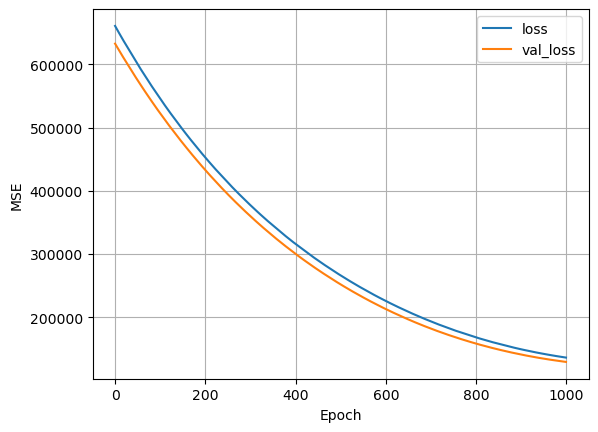

In [32]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


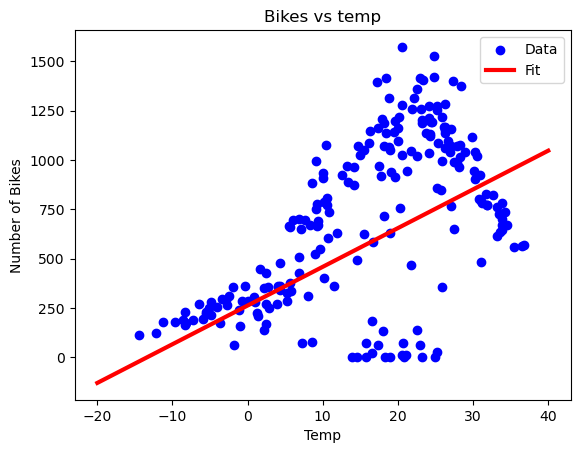

In [33]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color ='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)),label='Fit',color = 'red',linewidth=3)
plt.legend()
plt.title('Bikes vs temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

## NN

In [35]:
temp_normalizer =tf.keras.layers.Normalization(input_shape=(1,),axis =None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32,activation ='relu'),
    tf.keras.layers.Dense(32,activation ='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),loss ='mean_squared_error')

C:\Users\negip\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
history =nn_model.fit(
    X_train_temp,y_train_temp,
    validation_data =(X_val_temp,y_val_temp),
    verbose=0,epochs=100
)

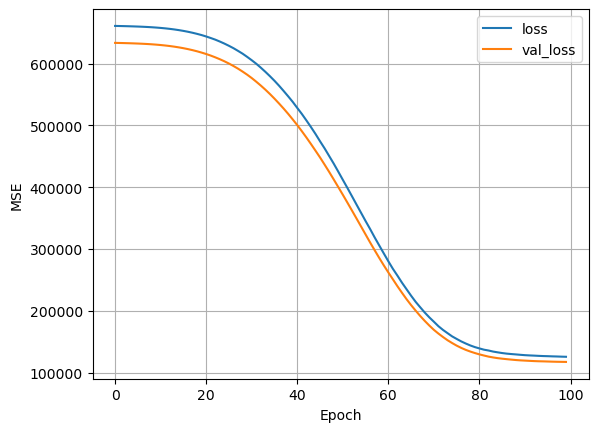

In [37]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


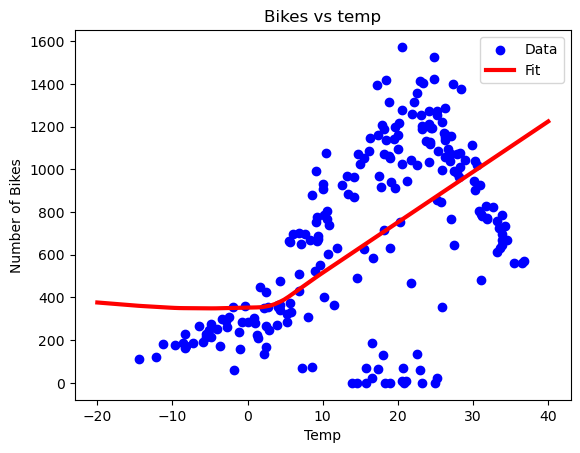

In [38]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color ='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)),label='Fit',color = 'red',linewidth=3)
plt.legend()
plt.title('Bikes vs temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

In [75]:
all_normalizer =tf.keras.layers.Normalization(input_shape=(6,),axis =-1)
all_normalizer.adapt(X_train_all)


nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32,activation ='relu'),
    tf.keras.layers.Dense(32,activation ='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),loss ='mean_squared_error')

C:\Users\negip\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


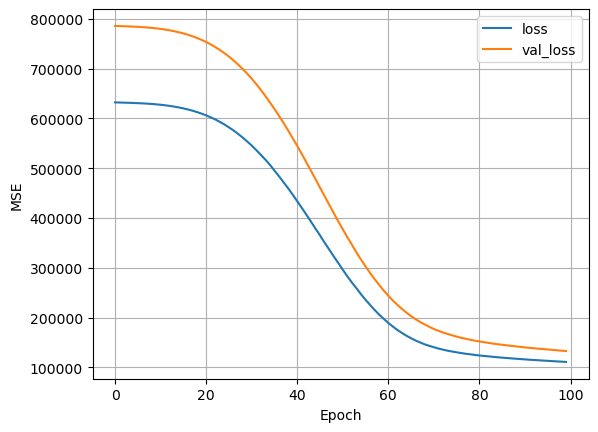

In [77]:
history = nn_model.fit(
    X_train_all,y_train_all,
    validation_data =(X_val_all,y_val_all),
    verbose=0,epochs=100
)

plot_loss(history)

In [84]:
# Calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [86]:
def MSE(y_pred,y_real):
     return (np.square(y_pred - y_real)).mean()

In [88]:
MSE(y_pred_lr,y_test_all)

113436.70913904061

In [90]:
MSE(y_pred_nn,y_test_all)

145580.5752399028

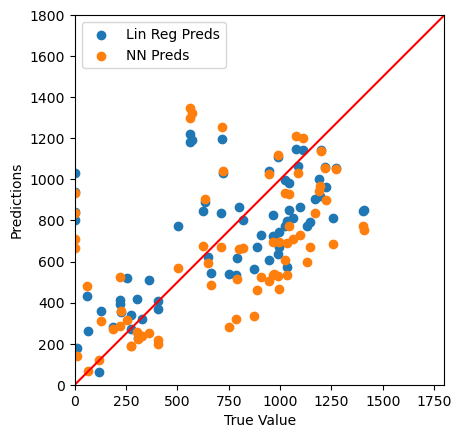

In [102]:
ax = plt.axes(aspect ='equal')
plt.scatter(y_test_all, y_pred_lr, label ='Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label ='NN Preds')
plt.xlabel("True Value")
plt.ylabel("Predictions")
lims =[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims,c='red')